## reference : https://github.com/JeCase/Thesis_SentimentAnalysis_IndoBERTweet_LSTM/blob/main/SentimentAnalysis_IndoBERTweet_ipnyb.ipynb

In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [44]:
import gc
import re
import joblib
import operator
import string
from collections import defaultdict
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings #to modify warnings
warnings.filterwarnings('ignore') #ignoring warnings
sns.set_style('darkgrid')

from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [47]:
df = pd.read_csv("../data/dataHasilPreprocessing/hasilPreprocessing1.csv")
df

,Ulasan,Sentimen
0,bahan celana bagus beliin si kaka ukur,Positif
1,kualitas bagus,Positif
2,ukur pas,Positif
3,bumil approved,Positif
4,ukur,Positif
...,...,...
893,bagus emas aja bagus banget koke sukakkk,Positif
894,foto jual ramah cmn kirim other than that love,Positif
895,nyampe sesuai mesan ukur nyah,Negatif
896,lumayan dalem oke makasih a ya,Positif


In [48]:
df = df.drop_duplicates(subset=['Ulasan'])

In [49]:
df = df.dropna()

In [50]:
df1 = df.copy()
arr = [df1]
for dataset in arr:    
  dataset.loc[(dataset['Sentimen'] == 'negatif'), 'Sentimen'] = 'Negatif'
  dataset.loc[(dataset['Sentimen'] == 'netral'), 'Sentimen'] = 'Netral'
  dataset.loc[(dataset['Sentimen'] == 'positif'), 'Sentimen'] = 'Positif'
df = df1

In [51]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

Sentimen
Positif    648
Negatif     20
Netral      16
Name: count, dtype: int64


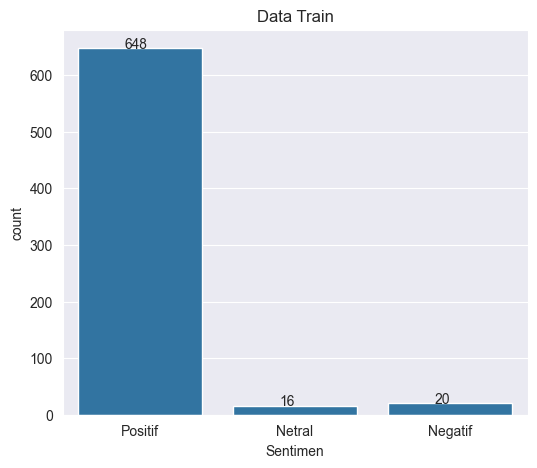

In [52]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data train
fig, ax = plt.subplots(figsize=(6, 5))
print(df_train['Sentimen'].value_counts())
ax = sns.countplot(x=df_train["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Train")
plt.show()

Sentimen
Positif    148
Negatif      3
Netral       2
Name: count, dtype: int64


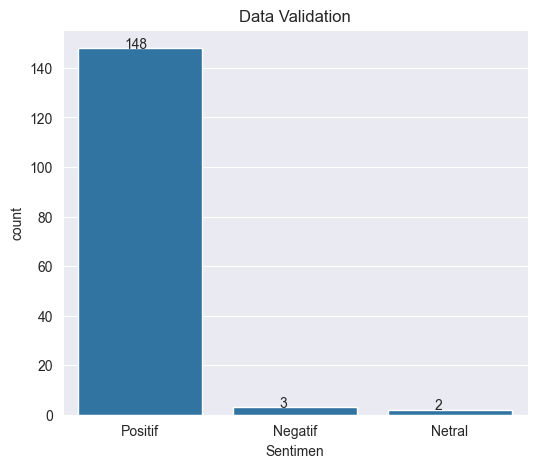

In [53]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data validasi
fig, ax = plt.subplots(figsize=(6, 5))
print(df_val['Sentimen'].value_counts())
ax = sns.countplot(x=df_val["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Validation")
plt.show()

Sentimen
Positif    18
Name: count, dtype: int64


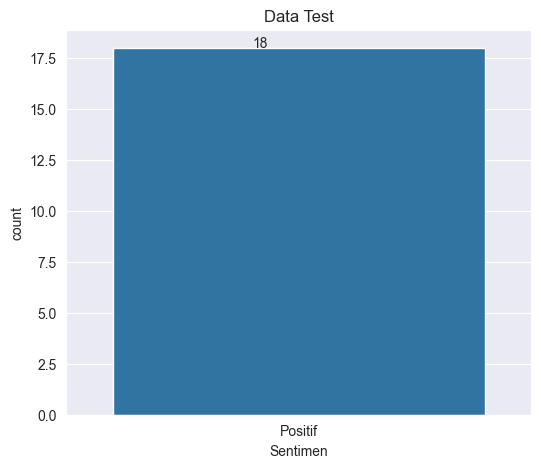

In [54]:
# Mengecek jumlah label "negatif": 0, "netral": 1, "positif": 2 pada data test
fig, ax = plt.subplots(figsize=(6, 5))
print(df_test['Sentimen'].value_counts())
ax = sns.countplot(x=df_test["Sentimen"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.05))
plt.title("Data Test")
plt.show()

In [55]:
print(f'Total Data Train    : {len(df_train)}')
print(f'Total Data Validasi : {len(df_val)}')
print(f'Total Data Test     : {len(df_test)}')

Total Data Train    : 684
Total Data Validasi : 153
Total Data Test     : 18


In [56]:
#Menyimpan data yang sudah dipisah kedalam google drive
df_train.to_csv("../data/dataHasilPreprocessing/train.csv", index=False)
df_val.to_csv("../data/dataHasilPreprocessing/eval.csv", index=False)
df_test.to_csv("../data/dataHasilPreprocessing/test.csv", index=False)

In [57]:
from datasets import load_dataset

files = {
    "train": "../data/dataHasilPreprocessing/train.csv", 
    "eval": "../data/dataHasilPreprocessing/eval.csv", 
    "test": "../data/dataHasilPreprocessing/test.csv",
}

dataset = load_dataset('csv', data_files=files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [58]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")

In [60]:
def tokenize_function(text):
    return tokenizer(text["Ulasan"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/684 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

In [61]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]
test_dataset = tokenized_datasets["test"]

In [62]:
test_dataset

Dataset({
    features: ['Ulasan', 'Sentimen', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18
})

In [64]:
cek_test = pd.DataFrame(test_dataset)
cek_test

,Ulasan,Sentimen,input_ids,token_type_ids,attention_mask
0,baguuss baguuss banget lebih ekspektasi sih ha...,Positif,"[3, 1663, 16002, 13292, 1663, 16002, 13292, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,model celana cantik nyaman pakai,Positif,"[3, 3956, 12387, 6823, 8015, 7563, 4, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,bagus enak pakai nyaman terimakasih,Positif,"[3, 4839, 8955, 7563, 8015, 17023, 4, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,bb kg tb cm lingkar pinggang ukur m pendek dik...,Positif,"[3, 4448, 7165, 8171, 5911, 17470, 14296, 1497...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,paket terima terimakasih sukses hasil nya muas,Positif,"[3, 6971, 5218, 17023, 4290, 2212, 2647, 29885...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
5,sesuai gambar respon jual cepat bagusp,Positif,"[3, 2768, 3894, 7235, 7880, 3218, 4839, 940, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
6,bagus bahan tebell,Positif,"[3, 4839, 2672, 20065, 932, 4, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,light grey warna spt light green,Positif,"[3, 13003, 6089, 950, 3889, 20219, 13003, 8717...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
8,bahan bagus adem nyaman model keren harga jangkau,Positif,"[3, 2672, 4839, 16401, 8015, 3956, 18639, 2661...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
9,baguuuuus banget,Positif,"[3, 1663, 22883, 944, 10218, 4, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Train Model

In [66]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [69]:
from transformers import BertForSequenceClassification 
model = BertForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)

ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFBertForSequenceClassification".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.
